In [1]:
import sys
sys.path.insert(0, "../../../")

In [2]:
import deeplay as dl
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torchvision
import lightning as L

In [3]:
# Load the MNIST dataset and normalize it to [-1, 1]

mnist = torchvision.datasets.MNIST(
    root="../../data", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

mnist_test = torchvision.datasets.MNIST(
    root="../../data", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

In [4]:
mnist_dataloader = torch.utils.data.DataLoader(mnist, batch_size=32, num_workers=4)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=32, num_workers=4)

### 1.1 Simple autoencoder

Simple autencoders only have an encoder and a decoder. The encoder takes the input data and returns the latent representation, while the decoder takes the latent vector and returns the decoded data.

In [5]:
autoencoder = dl.SimpleAutoencoder(hidden_dim=2)
autoencoder(mnist[0][0].unsqueeze(0))
autoencoder

SimpleAutoencoder(
  (encoder): Template(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layer): Linear(in_features=784, out_features=2, bias=True)
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Template(
    (layer): Linear(in_features=2, out_features=784, bias=True)
    (activation): Sigmoid()
    (unflatten): Unflatten(dim=1, unflattened_size=[1, 28, 28])
  )
  (loss): MSELoss()
)

In [6]:

def generate_examples(model, latent_range, n=5):
    import matplotlib.pyplot as plt
    import numpy as np
    import torchvision
    import torch
    plt.figure(figsize=(10, 10))
    x = np.linspace(latent_range[0][0], latent_range[1][0], n)
    y = np.linspace(latent_range[0][1], latent_range[1][1], n)

    xx, yy = np.meshgrid(x, y)
    xx = torch.tensor(xx).float()
    yy = torch.tensor(yy).float()
    z = torch.stack([xx, yy], dim=-1).view(-1, 2)
    yhat = model.decode(z).detach().cpu().numpy()

    for i in range(n ** 2):
        plt.subplot(n, n, i + 1)
        plt.imshow(yhat[i].transpose((1, 2, 0)), cmap="Greys_r")
        plt.axis("off")

    plt.tight_layout()


    

In [7]:


def scatterplot(model, testset):
    import matplotlib.pyplot as plt
    import numpy as np
    import torchvision
    import torch

    xy = torch.zeros((len(testset) * 32, 2))
    test_classes = torch.zeros((len(testset) * 32))

    i0 = 0
    for i, (x, y) in enumerate(testset):
        yhat = model.encode(x.view(-1, 1, 28, 28)).detach().cpu()
        xy[i:i + len(yhat)] = yhat
        test_classes[i:i + len(yhat)] = y.cpu().view(-1)

    latent_range = (
        xy.min(dim=0)[0],
        xy.max(dim=0)[0],
    )
   
    plt.figure(figsize=(10, 10))
    plt.scatter(xy[:, 0], xy[:, 1], c=test_classes, cmap="jet")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    return latent_range

In [8]:
autoencoder = dl.SimpleAutoencoder(hidden_dim=2)
autoencoder(torch.zeros((1, 1, 28, 28)))

trainer = L.Trainer(max_epochs=5, accelerator="cuda")
trainer.fit(autoencoder, mnist_dataloader, mnist_test_dataloader)
trainer.test(dataloaders=mnist_test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | encoder | Template | 1.6 K 
1 | decoder | Template | 2.4 K 
2 | loss    | MSELoss  | 0     
-------------------------------------
3.9 K     Trainable params
0         Non-trainable params
3.9 K     Total params
0.016     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\connectors\checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\autoencoders\lightning_logs\version_31\checkpoints\epoch=4-step=9375.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\autoencoders\lightning_logs\version_31\checkpoints\epoch=4-step=9375.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1450.7130126953125     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1450.7130126953125}]

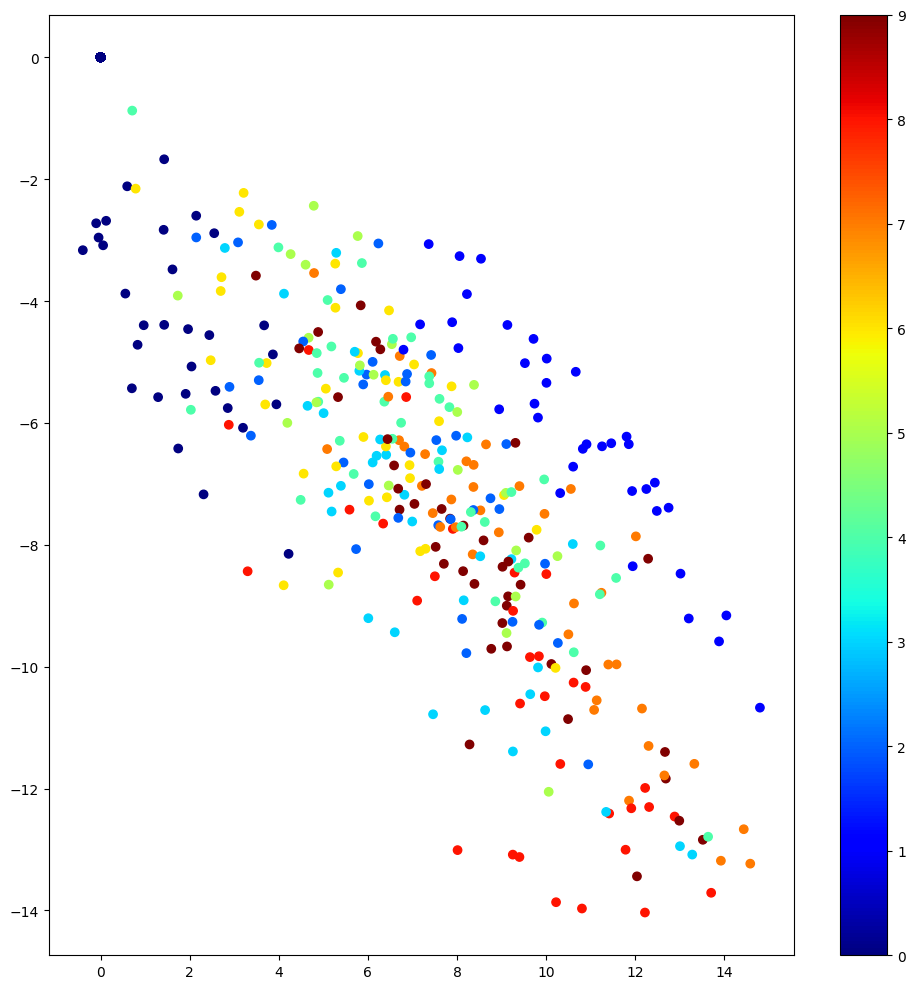

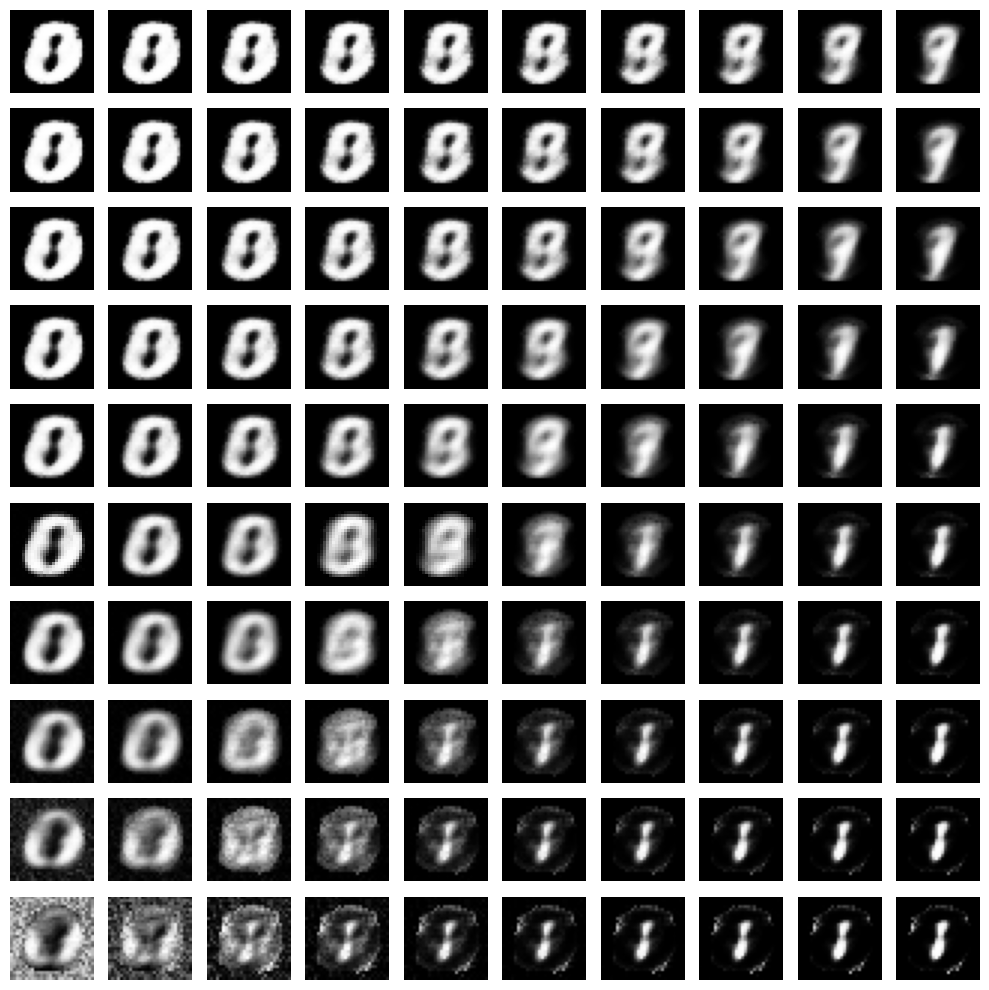

In [9]:
latent_range = scatterplot(autoencoder, mnist_test_dataloader)
generate_examples(autoencoder, latent_range, n=10)